# 네이버 영화 리뷰 텍스트 감성분석 하기

이전에 영문 텍스트에 대한 감정 분석을 진행해보았습니다. 이번에는 한국어 텍스트의 감성 분석을 진행해봅시다!

먼저 아래 커맨드로 파일을 다운로드 받은 후 `./data` 디렉토리로 옮겨줍시다.

```bash
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
```



## 데이터 준비와 확인

In [1]:
# 필요한 모듈 Import
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
# 데이터를 불러옵시다.
import os
data_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/'
train_data = pd.read_table(data_path + 'ratings_train.txt')
test_data = pd.read_table(data_path + 'ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


## 데이터 로더 구성

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전형 가공되지 않은 텍스트 파일로 되어있습니다. 이것을 읽어 자신만의 방법으로 imdb.data_loader()와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작한다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어 (Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 맅ㄴ



In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace = True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index : word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [7]:
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해본다.
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +4*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 :  15.971024731364448
문장 길이의 최대 :  116
문장 길이 표준 편차 :  12.844098490466033
pad_sequences maxlen :  67
전체 문장의 0.9975632106235826%가 maxlen 설정값 이내에 포함됩니다.


### 적절한 최대 문장 길이 지정 & `keras.preprocessing.sequence.pad_sequences`을 활용한 패딩 추가



In [8]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
print(x_train.shape)

(146182, 67)


## 모델 구성 및 validation set 구성

In [9]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 15 # 워드 벡터의 차원수

In [10]:
# 모델 설계. 위에서 만든 모델을 사용해봅시다.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 15)          150000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1696      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### validation set 분리

In [11]:
# validation set 10000건 분리
x_val = x_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


## 모델 훈련 개시

In [12]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 20

history = model.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/20
266/266 [==============================] - 5s 21ms/step - loss: 0.4693 - accuracy: 0.7779 - val_loss: 0.3426 - val_accuracy: 0.8506
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3182 - accuracy: 0.8658 - val_loss: 0.3297 - val_accuracy: 0.8561
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2860 - accuracy: 0.8813 - val_loss: 0.3294 - val_accuracy: 0.8563
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2605 - accuracy: 0.8945 - val_loss: 0.3358 - val_accuracy: 0.8578
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2349 - accuracy: 0.9069 - val_loss: 0.3463 - val_accuracy: 0.8557
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2088 - accuracy: 0.9208 - val_loss: 0.3647 - val_accuracy: 0.8542
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1841 - accuracy: 0.9322 - val_loss: 0.3896 - val_accuracy: 0.8480
Epoch

In [13]:
results = model.evaluate(x_test, y_test, verbose = 2)
print(results)

1537/1537 - 3s - loss: 0.8888 - accuracy: 0.8198
[0.8887985944747925, 0.8198018670082092]


In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Loss, Accuracy 그래프 시각화

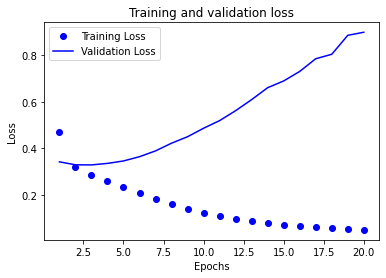

In [15]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

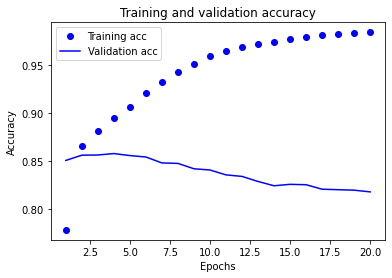

In [16]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

loss와 accuracy 모두 학습이 진행될수록 더 낮은 성능을 보이는 것을 확인할 수 있습니다. 좋지 않네요!!

여기에는 여러가지 이유가 있습니다. 먼저 데이터가 충분히 많지 않다는 점도 있을 수 있고, 단어 수를 좀 더 늘려야 하는 이유도 있을수가 있습니다.

이번에는 한국어 Word2Vec를 활용해서 성능을 개선해봅시다.

## 한국어 Word2Vec 임베딩을 활용하여 성능 개선

한국어 Word2Vec은 아래 링크에서 구할 수 있습니다.

- 박규병님이 만드신 한국어 Word2Vec 모델 : <https://github.com/Kyubyong/wordvectors>
- 위의 내용을 직접 다운로드 할 수 있는 링크 : <https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view>

In [17]:
import gensim

In [18]:
datapath = os.path.dirname(os.path.abspath('__file__')) + r'/data/ko/ko.bin'
word2vec = gensim.models.Word2Vec.load(datapath)

In [19]:
print(word2vec.wv.most_similar("강아지"))

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


In [20]:
vector = word2vec['컴퓨터']
vector.shape

/home/aiffel0039/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

잘 불러와진 것 같습니다. 이제 시작해봅시다.

In [21]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding matrix에 word2vec 워드를 단어 하나식마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0039/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0039/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [24]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                        embeddings_initializer = Constant(embedding_matrix),
                        input_length = maxlen,
                        trainable = True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 67, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [25]:
# 학습하기
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = epochs,
                   batch_size = 512, validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/20
266/266 [==============================] - 8s 29ms/step - loss: 0.5359 - accuracy: 0.7159 - val_loss: 0.4209 - val_accuracy: 0.8097
Epoch 2/20
266/266 [==============================] - 6s 22ms/step - loss: 0.3767 - accuracy: 0.8333 - val_loss: 0.3579 - val_accuracy: 0.8423
Epoch 3/20
266/266 [==============================] - 6s 21ms/step - loss: 0.3225 - accuracy: 0.8626 - val_loss: 0.3461 - val_accuracy: 0.8430
Epoch 4/20
266/266 [==============================] - 6s 22ms/step - loss: 0.2917 - accuracy: 0.8773 - val_loss: 0.3404 - val_accuracy: 0.8490
Epoch 5/20
266/266 [==============================] - 6s 22ms/step - loss: 0.2686 - accuracy: 0.8899 - val_loss: 0.3452 - val_accuracy: 0.8493
Epoch 6/20
266/266 [==============================] - 6s 22ms/step - loss: 0.2493 - accuracy: 0.8989 - val_loss: 0.3471 - val_accuracy: 0.8497
Epoch 7/20
266/266 [==============================] - 6s 22ms/step - loss: 0.2297 - accuracy: 0.9088 - val_loss: 0.3612 - val_accuracy: 0.8488

In [26]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.7164 - accuracy: 0.8298
[0.7164175510406494, 0.8297902345657349]


헉! 어떻게 된 일인지 성능이 더 떨어졌네요!

## Conclusion

어째서인지 한국어 Word2Vec 모델을 사용했을 때 더 성능이 저하되었습니다. 그에 대한 이유로는 여러가지 생각할 수 있을 것 같습니다.

- 영화 리뷰에 사용되는 언어는 어느정도 제한적이고, 작성할 때의 의도와 단어가 가진 의미가 다를 수 있습니다.
    - (예) 영화 정말 시간가는줄 잘 알고 봤습니다.
- stopwords를 좀 더 추가해도 좋을 것 같습니다. 실제로는 더 많은 stopwords들이 존재하기 때문이죠!


In [27]:
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:90% !important;}</style>"))